## Data Analysis Interview Challenge
# Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.




## Experiment and Metrics Design

Solutions
---




1) Key Measure of Success

The key measure of success should be the reduction in driver churn among drivers who begin serving both cities.
Although cross-city trips matter, the logistic regression shows that city is the strongest predictor of churn, meaning the two-way toll likely contributes to city-specific driver attrition. If toll reimbursement removes this friction, drivers should both (1) operate across cities and (2) remain active longer.
Secondary metrics: % of drivers active in both cities, cross-city trips per driver, and driver-hours in each city.


2) Experiment Design

a) Implementation

Run a driver-level randomized controlled trial (RCT) for 4–6 week

•	Treatment: Drivers receive full toll reimbursement.

•	Control: No reimbursement.

•	Stratification: By city, phone type, Ultimate Black status, and baseline
 activity (because these strongly predict churn in the model).
Collect data on cross-city trips, driver-hours, and churn.

b) Statistical Tests

Primary test: Logistic regression on churn:

churn ~ treatment + city + phone + ultimate_black_user + baseline_trips

This isolates the causal effect of toll reimbursement while controlling for major churn drivers.

Secondary tests:

•	Two-proportion Z-test (share of cross-city drivers)

•	Mann–Whitney U (cross-city trip counts)

•	Optional Difference-in-Differences

c) Interpretation  and  Recommendations

If treatment reduces churn and increases cross-city activity:

 Toll reimbursement is effective. Roll it out citywide.

If cross-city activity rises but churn does not:

Toll is only part of the friction; add earnings guarantees or return-trip incentives.

If no significant changes:

 Toll cost is not the key barrier. Investigate other issues (deadhead time, demand imbalance, unfamiliar areas).


In [ ]:
import os
import json
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)

## Exploratory Data Analysis

In [ ]:
#Load and Inspect the Data
import pandas as pd
import json
from datetime import datetime

# Load the logins.json file
with open("logins.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df['login_time'] = pd.to_datetime(df['login_time'])

df.head()


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [ ]:
import pandas as pd

# Aggregate into 15-minute intervals
# Ensure the DataFrame is properly indexed by 'login_time' for resampling.
# If 'login_time' is a column, set it as the index. Otherwise, assume it's already the index.
# Note: It's best practice to run the data loading cell (kEjSLHgN3w2Q) first to reset 'df'
# with 'login_time' as a column before running this cell if 'df' might have been altered.

# Set 'login_time' as the DataFrame index for resampling
df = df.set_index('login_time')

# Aggregate to 15-minute intervals and count logins
# This assumes 'df' is already a time-indexed DataFrame or has 'login_time' as an index.
login_counts = df.resample('15min').size().to_frame(name='logins')

login_counts.head()

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


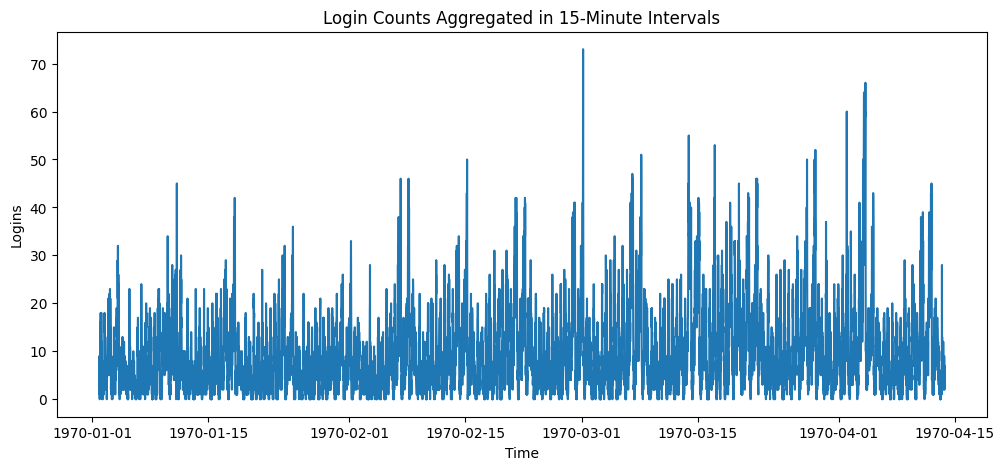

In [ ]:
#Plot Time Series
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(login_counts.index, login_counts['logins'])
plt.title("Login Counts Aggregated in 15-Minute Intervals")
plt.xlabel("Time")
plt.ylabel("Logins")
plt.show()


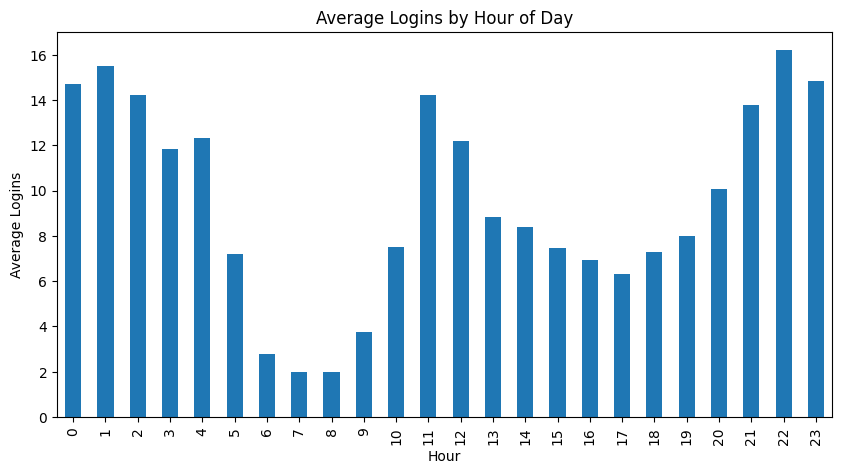

In [ ]:
#Daily Cycle Visualization
# Add hour
login_counts['hour'] = login_counts.index.hour

# Average logins by hour of day
hourly_pattern = login_counts.groupby('hour')['logins'].mean()

hourly_pattern.plot(kind='bar', figsize=(10,5))
plt.title("Average Logins by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Logins")
plt.show()


This pattern suggests that users are most active on the platform in the evenings and late at night, with another noticeable surge around lunchtime.

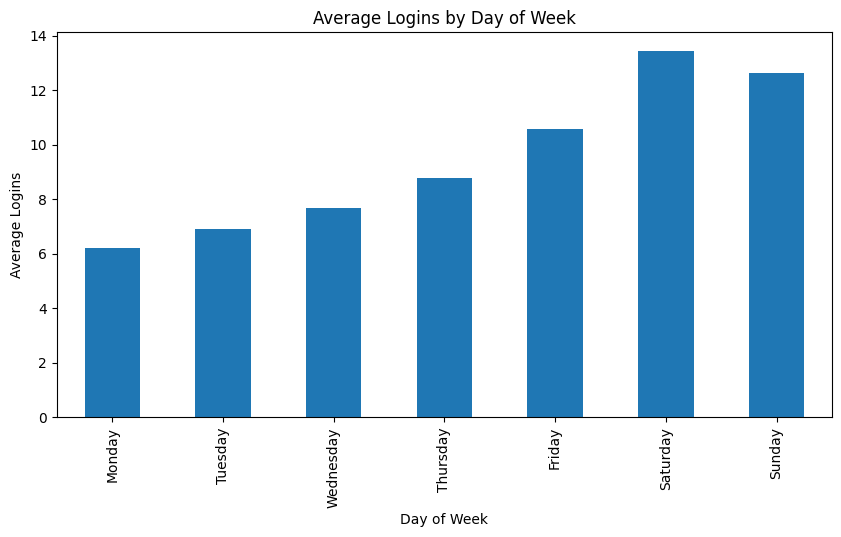

In [ ]:
#Day of Week Pattern
login_counts['day_of_week'] = login_counts.index.day_name()

dow_pattern = login_counts.groupby('day_of_week')['logins'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

dow_pattern.plot(kind='bar', figsize=(10,5))
plt.title("Average Logins by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Logins")
plt.show()

The  pattern displayed by this bar chart suggests that users are more active on the platform during weekends and towards the end of the work week.

# Predictive Modeling

In [ ]:
# Load and Clean Data
import pandas as pd
import json

# Read the entire JSON file as a single object
with open("ultimate_data_challenge.json", "r") as f:
    data = json.load(f) # Load the entire JSON content

# Create DataFrame directly from the loaded list of dictionaries
df = pd.DataFrame(data)

# Convert dates safely
df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], errors='coerce')

# Inspect structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [ ]:
display(df.describe())

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000,41878.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778158
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.300000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000
50%,1.000000,2014-01-17 00:00:00,4.900000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,3.792684,NaN,0.617338,0.222336,NaN,19.958811,37.081503,5.707357,0.446652


This shows the summary of the statistical distribution of the numerical columns in the  DataFrame

In [ ]:
#Create Retention Label
snapshot_date = df['last_trip_date'].max()

df['retained'] = (snapshot_date - df['last_trip_date']).dt.days <= 30

df['retained'].mean()   # fraction retained


np.float64(0.37608)

## EDA

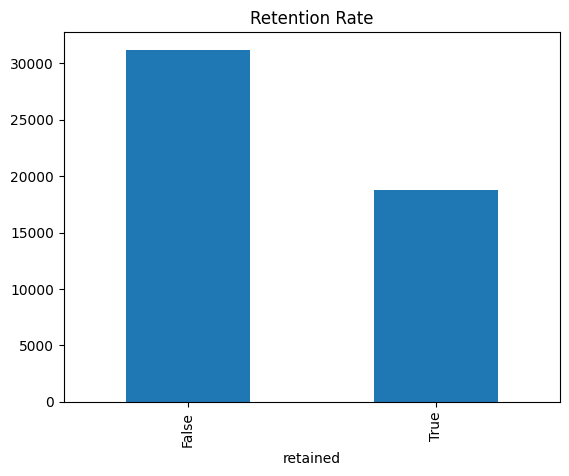

In [ ]:
#import library
import matplotlib.pyplot as plt

df['retained'].value_counts().plot(kind='bar')
plt.title("Retention Rate")
plt.show()


The Retention Rate bar chart visually shows that a significantly larger portion of users were not retained (False) compared to those who were retained (True). This indicates a retention rate lower than 50%

## Feature Engineering

In [ ]:
# Encode categorical variables
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# Drop date fields
df_model = df.drop(columns=['signup_date','last_trip_date'])


## Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop('retained', axis=1)
y = df_model['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Impute missing values with the median (or mean, depending on preference)
# Identify numerical columns that might contain NaNs in X_train
numerical_cols_with_nan = ['avg_rating_of_driver', 'avg_rating_by_driver'] # Based on df.info() and common sense

imputer = SimpleImputer(strategy='median')

# Fit on training data and transform both train and test sets
X_train[numerical_cols_with_nan] = imputer.fit_transform(X_train[numerical_cols_with_nan])
X_test[numerical_cols_with_nan] = imputer.transform(X_test[numerical_cols_with_nan])

model = LogisticRegression(max_iter=500, solver='liblinear') # Added solver for potential convergence warnings
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, solver='liblinear')

## Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred))
print("AUC:", roc_auc_score(y_test, proba))


              precision    recall  f1-score   support

       False       0.74      0.85      0.79      9379
        True       0.66      0.50      0.57      5621

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000

AUC: 0.7611699148314759


Score of 0.76 suggests that the  logistic regression model has reasonably good predictive power and is significantly better than randomly guessing. This is a decent result, but there might be room for improvement with further model tuning or .

## Feature Importance

In [ ]:
import numpy as np

coeffs = pd.DataFrame({
    'feature': X.columns,
    'importance': model.coef_[0]
}).sort_values(by='importance', ascending=False)

coeffs


,feature,importance
8,city_King's Landing,1.725234
10,phone_iPhone,1.062397
4,ultimate_black_user,0.874615
9,city_Winterfell,0.517216
0,trips_in_first_30_days,0.122842
3,surge_pct,0.004455
5,weekday_pct,-0.000263
6,avg_dist,-0.034740
1,avg_rating_of_driver,-0.124720
7,avg_rating_by_driver,-0.140636


These coefficients represent the impact each feature has on the log-odds of a user being retained. Finally, it sorts this DataFrame by 'importance' in descending order, showing which features have the strongest positive or negative influence on the prediction.